# Starter Notebook

Install and import required libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3
!pip install googletrans
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np
import random
import unicodedata
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle
from collections import Counter
import string
from random import shuffle

from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig, AutoTokenizer
from peft import prepare_model_for_kbit_training

import re

!pip install nlpaug
import nlpaug.augmenter.word as naw
import nltk

from nltk.tokenize import sent_tokenize

from googletrans import Translator

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer

from transformers import (
    RobertaTokenizer,
    MarianMTModel,
    MarianTokenizer
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.3 MB/s eta 0:00:00


In [3]:
import transformers
print(transformers.__version__)

4.51.3


In [4]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Required for WordNet lemmatization

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Load Tokenizer and Preprocess Data

In [5]:
base_model = 'roberta-base'
dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

########################################
# 1) HELPER FUNCTIONS
########################################

def normalize_chars_and_dots(text):
    """
    Example: convert funky unicode characters to standard,
    handle weird spacing around dots, etc.
    """
    # Normalize to NFC form (standard in many NLP pipelines)
    text = unicodedata.normalize('NFC', text)
    return text

def remove_hrefs(text):
    """
    Removes explicit HTML href=... code snippets if they appear.
    For example: <a href="http://..."> or similar.
    """
    # Remove <a href="..."> while leaving link text
    # <a href="...">some text</a> => some text
    text = re.sub(r'<a\s+href="[^"]*">', '', text, flags=re.IGNORECASE)
    text = re.sub(r'</a>', '', text, flags=re.IGNORECASE)
    return text

def remove_html_tags(text):
    """Remove any remaining HTML tags."""
    text = re.sub(r'<[^>]+>', ' ', text)
    return text

def remove_bad_symbols(text):
    # Keep letters, numbers, basic punctuation, and space/apostrophes
    text = re.sub(r"[^a-zA-Z0-9\s\.,!?'\"]", ' ', text)
    return text

def remove_repeated_punct(text):
    """
    Remove duplicated dots, question marks, exclamations.
    e.g. "Hello!!!???" -> "Hello!?". Or remove extra punctuation altogether.
    """
    text = re.sub(r'[.]{2,}', '.', text)   # repeated dots -> single .
    text = re.sub(r'[?]{2,}', '?', text)   # repeated ? -> single ?
    text = re.sub(r'[!]{2,}', '!', text)   # repeated ! -> single !
    return text

def remove_extra_whitespace(text):
    """Remove extra spaces and strip leading/trailing whitespace."""
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

########################################
# SMART LINK REMOVAL
########################################

def domain_search(full_url):
    """
    Extract something like the domain or key text from a URL.
    For example, 'https://www.cnn.com/article/worldnews' -> 'cnn worldnews'
    or simply 'cnn' if you prefer. Adjust to your liking.
    """
    # 1) Remove protocol prefix
    no_protocol = re.sub(r'^https?:\/\/', '', full_url, flags=re.IGNORECASE)

    # 2) Split on '/' to separate domain from path
    parts = no_protocol.split('/')

    # 3) First chunk is the domain
    domain = parts[0]
    domain = domain.replace('www.', '')
    domain = re.sub(r'[^\w]', ' ', domain)  # keep letters/numbers in domain

    # 4) keep path words as well
    # E.g. "cnn . com article worldnews"
    path_words = []
    if len(parts) > 1:
        for p in parts[1:]:
            # remove query params etc.
            p = p.split('?')[0]
            p = re.sub(r'[^\w]', ' ', p)
            if p.strip():
                path_words.append(p.strip())

    # Combine domain + path (if you want them)
    combined = domain.strip()
    if path_words:
        combined += ' ' + ' '.join(path_words)
    return combined.strip()

def place_hold(text):
    return f"<URL:{text}>"

def smart_link_cleanup(text, url_rule=r'(?P<url>https?://[^\s]+)'):
    """
    Remove or transform links but keep some important 'words' from them.
    This uses the domain_search logic to keep domain/path.
    """
    # Find all matches
    pattern = re.compile(url_rule, flags=re.IGNORECASE)
    matches = pattern.finditer(text)

    # build a dictionary { original_link : replacement_text }
    replacement_dict = {}

    for match in matches:
        orig_url = match.group('url')
        domain_text = domain_search(orig_url)

        # Decide how to replace. E.g., if domain_text is empty, fallback to <URL>
        if domain_text:
            replacement_text = place_hold(domain_text)
        else:
            replacement_text = "<URL>"

        replacement_dict[orig_url] = replacement_text

    # to avoid interfering with multiple matches, do safe replace
    for old_val, new_val in replacement_dict.items():
        text = text.replace(old_val, new_val)

    return text

def apply_stemming_and_lemmatization(text):
    """Apply both stemming and lemmatization to text"""
    tokens = nltk.word_tokenize(text)
    processed_tokens = []
    for token in tokens:
        # Apply both stemming and lemmatization
        stemmed = stemmer.stem(token)
        lemmatized = lemmatizer.lemmatize(stemmed)
        processed_tokens.append(lemmatized)
    return ' '.join(processed_tokens)

def remove_stopwords(text):
    """Remove common stop words from text"""
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

def random_char_manipulation(text, prob=0.1):
    """
    Randomly deletes, inserts, or swaps characters with given probability
    """
    if not text or len(text) < 3:  # Skip very short texts
        return text

    result = []
    for char in text:
        if char == ' ' or random.random() > prob:
            result.append(char)
            continue

        # Random operation selection
        op = random.choice(['delete', 'insert', 'swap'])

        if op == 'delete':
            continue  # Skip this character

        elif op == 'insert':
            # Insert random lowercase letter or number
            new_char = random.choice('abcdefghijklmnopqrstuvwxyz0123456789')
            result.append(char)
            result.append(new_char)

        elif op == 'swap' and len(result) > 0:
            # Swap with previous character
            result[-1], char = char, result[-1]
            result.append(char)

    return ''.join(result)

def synonym_replacement(text, prob=0.3):
    """
    Replace words with synonyms using WordNet
    """
    words = text.split()
    for i in range(len(words)):
        if random.random() < prob:
            syns = []
            for syn in wordnet.synsets(words[i]):
                for lemma in syn.lemmas():
                    syns.append(lemma.name())
            if syns:
                # Choose a synonym that's different from original
                unique_syns = list(set(syns))
                if len(unique_syns) > 1:
                    new_word = random.choice(unique_syns)
                    words[i] = new_word.replace('_', ' ')
    return ' '.join(words)

def introduce_obfuscations(text, prob=0.2):
    """
    Add various obfuscations like:
    - Number substitutions (e.g., 'to' -> '2')
    - Leet speak substitutions
    """
    leet_dict = {
        'a': ['4', '@'],
        'e': ['3'],
        'i': ['1', '!'],
        'o': ['0'],
        's': ['5', '$'],
        't': ['7']
    }

    # Number substitutions
    if random.random() < prob/3:
        text = text.replace(' to ', ' 2 ')
        text = text.replace(' for ', ' 4 ')
        text = text.replace(' you ', ' u ')

    # Leet speak
    if random.random() < prob/3:
        result = []
        for char in text:
            if char.lower() in leet_dict and random.random() < 0.3:
                result.append(random.choice(leet_dict[char.lower()]))
            else:
                result.append(char)
        text = ''.join(result)

    return text

import asyncio

async def back_translate_async(text, src_lang='en', intermediate_lang='fr'):
    translator = Translator()
    # Translate to intermediate language (await because it returns a coroutine)
    translated = await translator.translate(text, src=src_lang, dest=intermediate_lang)
    # Translate back
    back_translated = await translator.translate(translated.text, src=intermediate_lang, dest=src_lang)
    return back_translated.text

# Then run in an event loop
def back_translate(text):
    return asyncio.run(back_translate_async(text))


def swap_sentences(text):
    """
    Randomly swap sentences if multiple sentences exist
    """
    sentences = nltk.sent_tokenize(text)
    if len(sentences) > 1:
        shuffle(sentences)
        return ' '.join(sentences)
    return text




########################################
# MAIN CLEANING FUNCTION
########################################

def cleanup_text(text):
    # 0) Lowercase
    text = text.lower()

    # 1) Normalize
    text = normalize_chars_and_dots(text)

    # 2) Remove href code
    text = remove_hrefs(text)

    # 3) Remove bad symbols
    text = remove_bad_symbols(text)

    # 4) Remove HTML tags
    text = remove_html_tags(text)

    # 5) Smart link cleanup
    text = smart_link_cleanup(text)

    # 6) Remove repeated punctuation
    text = remove_repeated_punct(text)

    text = apply_stemming_and_lemmatization(text)

    text = remove_stopwords(text)

    text = random_char_manipulation(text)

    text = synonym_replacement(text)

    text = introduce_obfuscations(text)

    if random.random() < 0.015:
          try:
            new_text = back_translate(text)
          except Exception as e:
            print(f"Back translation failed: {e}")
            new_text = text  # fallback if there's an error

          text = new_text

    text = swap_sentences(text)

    # 7) Remove extra whitespace
    text = remove_extra_whitespace(text)

    return text

########################################
# APPLY TO AG_NEWS
########################################

def preprocess_ag_news(example):
    """Apply cleanup_text to each row's 'text' column."""
    cleaned = cleanup_text(example['text'])
    return {'text': cleaned}

dataset = dataset.map(preprocess_ag_news, batched=False, num_proc=4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/120000 [00:00<?, ? examples/s]

In [6]:
def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(
    preprocess,
    batched=True,  # Now processing batches for efficiency
    remove_columns=['text'],  # Remove original text column
    num_proc=4
)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

Map (num_proc=4):   0%|          | 0/120000 [00:00<?, ? examples/s]

In [7]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [8]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [10]:
# tokenized_dataset = tokenized_dataset.remove_columns(['label'])
tokenized_dataset.column_names

['labels', 'input_ids', 'attention_mask']

## Anything from here on can be modified

In [11]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [12]:
# PEFT Config

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.25,
    bias='none',
    target_modules=['query'],
    task_type="SEQ_CLS"
)

peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.25, inplace=False)
                    )
                    (lora_A): Mo

In [15]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 741,124 || all params: 125,389,832 || trainable%: 0.5911


## Training Setup

In [18]:
os.environ["WANDB_DISABLED"] = "true"

In [19]:

from transformers import TrainingArguments, Trainer, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
import torch

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy}

# Setup Training args
output_dir = "results"

training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='steps',
    eval_steps=100,
    logging_steps=100,
    num_train_epochs=2,
    learning_rate=3e-4,
    weight_decay=0.21,
    gradient_accumulation_steps=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    use_cpu=False,
    optim="adamw_torch",
    warmup_steps=200,
    lr_scheduler_type="cosine",
    label_smoothing_factor=0.05,
    dataloader_num_workers=4,
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant': True},
    metric_for_best_model="accuracy",
    greater_is_better=True,
    load_best_model_at_end=True,
)


def get_trainer(model):
    return Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
    )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


### Start Training

In [20]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy
100,1.373100,1.270316,0.610938
200,0.878400,0.754710,0.767188
300,0.736500,0.716536,0.785937
400,0.722900,0.708816,0.789062
500,0.711800,0.680676,0.804688
600,0.678300,0.700436,0.804688
700,0.693000,0.665565,0.806250
800,0.683800,0.657939,0.806250
900,0.652800,0.656578,0.815625
1000,0.669900,0.633481,0.812500


## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [21]:
# def classify(model, tokenizer, text):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
#     output = model(**inputs)

#     prediction = output.logits.argmax(dim=-1).item()

#     print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
#     return id2label[prediction]

In [22]:
# classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
# classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")

### Run Inference on eval_dataset

In [23]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [24]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:02<00:00, 26.96it/s]

Evaluation Metric: {'accuracy': 0.8328125}


### Run Inference on unlabelled dataset

In [25]:
def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [26]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:28<00:00, 34.88it/s]

Inference complete. Predictions saved to inference_output.csv


In [54]:
import matplotlib.pyplot as plt
import os

def plot_loss_curve(trainer):
    log_history = trainer.state.log_history
    train_steps = [entry['step'] for entry in log_history if 'loss' in entry]
    train_losses = [entry['loss'] for entry in log_history if 'loss' in entry]
    eval_steps = [entry['step'] for entry in log_history if 'eval_loss' in entry]
    eval_losses = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]

    plt.figure(figsize=(7, 5))
    if train_steps:
        plt.plot(train_steps, train_losses, label="Train Loss", color='blue')
    if eval_steps:
        plt.plot(eval_steps, eval_losses, label="Eval Loss", color='red')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Loss Curve (Train vs Eval)")
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(trainer.args.output_dir, "loss_curve.png"))
    plt.show()

def plot_eval_accuracy(trainer):
    log_history = trainer.state.log_history
    eval_steps = [entry['step'] for entry in log_history if 'eval_accuracy' in entry]
    eval_accuracies = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]

    plt.figure(figsize=(7, 5))
    if eval_steps:
        plt.plot(eval_steps, eval_accuracies, label="Eval Accuracy", color='green')
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy Curve")
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(trainer.args.output_dir, "eval_accuracy.png"))
    plt.show()

def plot_lr(trainer):
    log_history = trainer.state.log_history
    lr_steps = [entry['step'] for entry in log_history if 'learning_rate' in entry]
    lrs = [entry['learning_rate'] for entry in log_history if 'learning_rate' in entry]

    plt.figure(figsize=(7, 5))
    plt.plot(lr_steps, lrs, label="Learning Rate", color='magenta')
    plt.xlabel("Steps")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(trainer.args.output_dir, "lr_schedule.png"))
    plt.show()

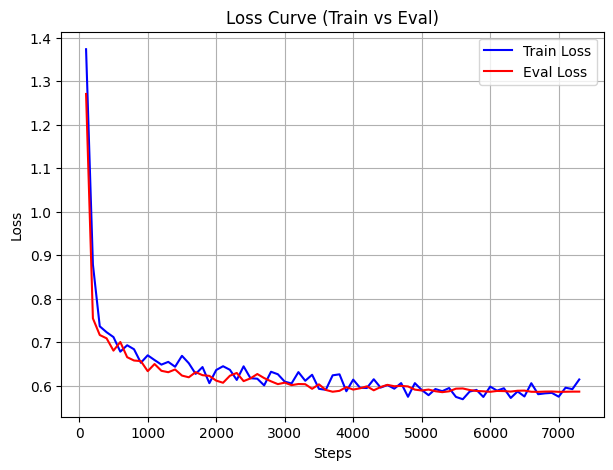

In [55]:
plot_loss_curve(peft_lora_finetuning_trainer)

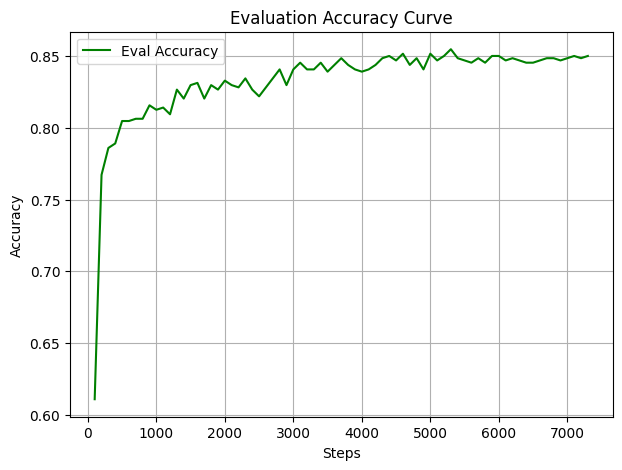

In [57]:
plot_eval_accuracy(peft_lora_finetuning_trainer)

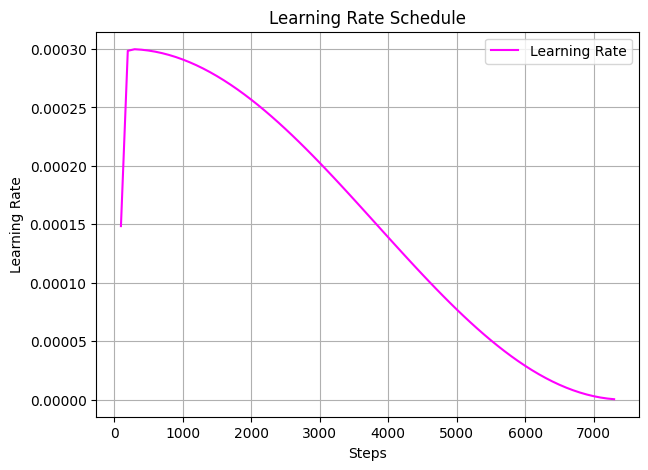

In [58]:
plot_lr(peft_lora_finetuning_trainer)